# Gradient Boosting Regressor

In this notebook we study the model of Gradient Boosting for Regression, in the context of regression problems. As in the other notebook, we will introduce the model from a theoretical point of view and then we apply it to a concrete example in a mini-challenge.


## Table of Contents


- [Theoretical Analysis:](#s1)
    - [Algorithm](#s1.2)
    - [Hyperparameters](#s1.3)
    - [Interpretability](#s1.4)
    
- [Implementation of XGBoost](#s2)
- [Mini-challenge](#s3)

<hr style="border: dashed rgb(0,1,0) 0.9px"/>

<a id='s1'></a>
## Theoretical Analysis

__Gradient Boosting__ is an __ensemble learning__ methods for classification, regression and other tasks that operate by constructing a multitude of decision trees.

The idea of ensemble learning, as explained in the notebook where we studied the Random Forest model, is to build a prediction model by combining the strengths of a collection of simpler base models called __weak learners__ or __base learners__. A model comprised of many models is called an __ensemble model__.

Even though there are [several models](https://en.wikipedia.org/wiki/Ensemble_learning#Common_types_of_ensembles) fitting in the class of ensemble models, we refer in general to two main classes of ensemble models:

1. __Boosting__ : Boosting refers to a group of algorithms that utilize weighted averages to make weak learners into stronger learners. Each model that runs, dictates what features the next model will focus on. In boosting as the name suggests, one is learning from other which in turn boosts the learning.


2. __Bootstrap Aggregation (Bagging)__: Bootstrap refers to random sampling with replacement. Bootstrap allows us to better understand the bias and the variance with the dataset. Bootstrap involves random sampling of small subset of data from the dataset. It is a general procedure that can be used to reduce the variance for those algorithm that have high variance, typically decision trees. Bagging makes each model run independently and then aggregates the outputs at the end without preference to any model.



Boosting models work in the same spirit as bagging models: we build a family of weak models that are aggregated to obtain a strong learner that performs better.
However, unlike bagging that mainly aims at reducing variance, boosting is a technique that consists in fitting sequentially multiple weak learners in a very adaptative way: each model in the sequence is fitted giving more importance to observations in the dataset that were badly handled by the previous models in the sequence. 




<div>
<img width=500 src='images/boost1.png' /> 
</div>





Intuitively, each new model focus its efforts on the most difficult observations to fit up to now, so that we obtain, at the end of the process, a strong learner with lower bias. Being mainly focused at reducing bias, the base models that are often considered for boosting are models with low variance but high bias. For example, if we want to use trees as our base models, we will choose most of the time shallow decision trees with only a few depths. Another important reason that motivates the use of low variance but high bias models as weak learners for boosting is that these models are in general less computationally expensive to fit (few degrees of freedom when parametrised). Indeed, as computations to fit the different models can’t be done in parallel, it could become too expensive to fit sequentially several complex models. 
Once the weak learners have been chosen, we still need to define how they will be sequentially fitted and how they will be aggregated. The different ways in which this happend give rise to different models of boosting. The very first boosting model, called __Adaptive Boosting (AdaBoost)__, was due to Freund and Schapire (1997). Another broadly used and more common nowdays boosting model is what is called __Gradient Boosting__. The Adaptive and Gradient Boosting are two [meta-algorithms](https://en.wikipedia.org/wiki/Metaheuristic) that differ on their optimization algorithm.
We try to give an introduction to these two model and to the general idea of boosting, and in the next section we will focus more in details on a specific boosting model. 



As usually happen in supervised learning problem we have an output variable $y$ and a vector of input variables $X$ described via a joint probability distribution $P(x,y)$. One wants to find a function $\hat{f}(x)$ amongst a family of models $\mathcal{H}$ by minimizing the expectation value over the joint probability of some given loss function $L(y,f(x))$, namely:



\begin{equation*}
\hat{f}=\arg\min_{f\in\mathcal{H}}E_{(x,y)}\left[L(y,f(x))\right]
\end{equation*}

Since we don't know the joint distribution we usually define an emipirical risk function $\hat{\mathcal{R}}(f)$ defined on the training dataset we are given $(X,y)=\{(x_1,y_1),\cdots (x_N,y_N)\}$, such that:



\begin{equation*}
\hat{f}=\arg\min_{f\in\mathcal{H}}\hat{\mathcal{R}}(f)=\arg\min_{f\in\mathcal{H}}\frac{1}{N}\sum_{i=1}^N\left[L(y_i, f(x_i))\right]
\end{equation*}


In the case of linear regression, for example, we restrict the family $\mathcal{H}$ to the class of linear functions $f(x)=\theta x$ and the optimization problem becomes an minimization problem with respect the parameter vector $\theta$. 


In boosting models, we define our ensemble model as a weighted sum of $M$ weak learners:



\begin{equation*}
f=\sum_{m=1}^M\alpha_mk_m
\end{equation*}

where $\alpha_m$'s are coefficients and $k_m$'s are weak learners models. 

Finding the best ensemble model with this form is a difficult optimisation problem. Then, instead of trying to solve it in one single shot (finding all the coefficients and weak learners that give the best overall additive model), we make use of an iterative optimisation process that is much more tractable, even if it can lead to a sub-optimal solution. More especially, we add the weak learners one by one, looking at each iteration for the best possible pair (coefficient, weak learner) to add to the current ensemble model:



\begin{equation*}
f_m=f_{m-1}+\alpha_mk_m
\end{equation*}

where $\alpha_m$ and $k_m$ are chosen such that $f_m$ is the model that fit the best the training data and so, that is the best possible improvement over $f_{m-1}$:


\begin{equation*}
\left(\alpha_m, k_m\right)=\arg\min_{\alpha, k}\sum_{i=1}^NL(y_i, f_{m-1}(x_i)+\alpha k(x_i))
\end{equation*}


Thus, instead of optimising “globally” over all the $M$ models in the sum, we approximate the optimum by optimising “locally” building and adding the weak learners to the strong model one by one. 

The way they use to solve this optimization problem makes the difference between boosting models. 
Adaptive and Gradient Boosting differ on how they create and aggregate the weak learners during the sequential process. Adaptive boosting updates the weights attached to each of the training dataset observations whereas gradient boosting updates the value of these observations. This main difference comes from the way both methods try to solve the optimisation problem of finding the best model that can be written as a weighted sum of weak learners.


We are now turning on describing in more details the __Gradient Boosting__ model algortihm. 



<a id='s1.2'></a>
###  Algorithm

The Gradient Boosting Regressor algorithm follows from the previous discussion, and in particular we recall the definition of the ensemble learner:

\begin{equation*}
f=\sum_{m=1}^M\alpha_mk_m
\end{equation*}

where again $\alpha_m$'s are coefficients and $k_m$'s are weak learners models. We defined also the partial sum:

\begin{equation*}
f_m=f_{m-1}+\alpha_mk_m
\end{equation*}

As we said, the idea of boosting we said is to solve the local optimization problem:


\begin{equation*}
\left(\alpha_m, k_m\right)=\arg\min_{\alpha, k}\sum_{i=1}^NL(y_i, f_{m-1}(x_i)+\alpha k(x_i))
\end{equation*}

and iteratively continue to update the ensemble learner until we reach $M$ a size we are given as input, togheter with the training data. The Gradient Boosting algorithm starts by defining the first iteration as a constant function:

\begin{equation*}
f_0=\arg\min_{\alpha}\sum_{i=1}^NL(y_i,\alpha)
\end{equation*}

and the following as 

\begin{equation*}
f_m=f_{m-1}+\arg\min_{k\in\mathcal{H}}\sum_{i=1}^NL(y_i, f_{m-1}(x_i)+\alpha k(x_i))
\end{equation*}

where $k\in\mathcal{H}$ is a weak learner model. Unfortunately, choosing the best function $k$ at each step for an arbitrary loss function $L$ is a computationally infeasible optimization problem in general. Therefore, the idea of gradient boosting is to apply a steepest descent step to this minimization problem, that in this case will be a funcitonal gradient descent. Therefore, for $m=1,\cdots M$  we define the __pseudo-residuals__:

\begin{equation*}
r_{im}=-\left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=f_{m-1}(x)}, \quad\text{for}\, i=1,\cdots, N
\end{equation*}

Then we fit a base learner $k_m$ to this pseudo residuals $r_{im}$, i.e., training it using the training set $\{(x_i,r_{im})\}_{i=1}^N$. The coefficient $\alpha_m$ will be then determined by solving the one dimensional optimization problem:

\begin{equation*}
\alpha_m=\arg\min_{\alpha}\sum_{i=1}^N L(y_i, F_{m-1}+\alpha k_m(x_i))
\end{equation*}

and finally we update the model 

\begin{equation*}
f_m=f_{m-1}+\alpha_m k_m
\end{equation*}

Repeating this procedure $M$ times we will get the final model $\hat{f}=f_M$.

\begin{equation*}
f_m=f_{m-1}+\arg\min_{k\in\mathcal{H}}\sum_{i=1}^NL(y_i, f_{m-1}(x_i)+\alpha k(x_i))
\end{equation*}

$\quad$

$\quad$

Gradient boosting is typically used with decision trees of a fixed size as base learners. For this special case, Friedman proposes a modification to gradient boosting method which improves the quality of fit of each base learner.

Generic gradient boosting at the $m$-th step would fit a decision tree $k_m$ to the pseudo-residuals. Let's $J_m$ be the number of its leaves. The tree partitions the input space into $J_m$ disjoint regions $R_{1m},\cdots, R_{J_mm}$ and predicts a constant value in each region. Using the indicator notation, the output of $k_m(X)$ for the input $X$ can be written as the sum:




\begin{align}
k_m(x_i)=\sum_{j=1}^{J_m}b_{jm}\mathbf{1}_{R_{jm}}(x_i)
\end{align}



where 




\begin{align}
\mathbf{1}_{R_{jm}}(x_i)= \begin{cases} 
   0   &x_i\notin R_{jm} \\
   1   &x_i\in R_{jm}
  \end{cases}
\end{align}


$b_{jm}$ is the value predicted in the region $R_{jm}$, namely the average


\begin{align}
b_{jm}=\text{ave}(y_i|x_i\in R_{jm})
\end{align}

$\quad$

Then the coefficients $b_{jm}$ are multiplied by some value $\alpha_m$, chosen using line search so as to minimize the loss function, and the model is update as follows:

$\quad$

\begin{align}
f_m&=f_{m-1}+\alpha_m k_m\\
\alpha_m&=\arg\min_{\alpha}\sum_{i=1}^N L(y_i, F_{m-1}+\alpha k_m(x_i))
\end{align}


Friedman proposes to modify this algorithm so that it chooses a separate optimal value $\alpha_{jm}$ for each of the tree's regions, instead of a single $\alpha_m$ for the whole tree. He calls the modified model the __TreeBoost__. The coefficients $b_{jm}$ from the tree-fitting procedure can be then simply discarded and the model update rule becomes:

\begin{align}
f_m&=f_{m-1}+\sum_{j=1}^{J_m}\alpha_{jm}\mathbf{1}_{R_{jm}}(X)\\
\alpha_{jm}&=\arg\min_{\alpha}\sum_{x_i\in R_{jm}} L(y_i, F_{m-1}(x_i)+\alpha)
\end{align}

















<a id='s1.3'></a>
### Hyperparameters 

Two basic tuning parameters are the number of iterations $M$ and the sizes of each of the constituent trees $J_m$, $m=1,2,...,M$.

Historically, boosting was considered to be a technique for combining models, here trees. As such, the tree building algorithm was regarded as a primitive that produced models to be combined by the boosting procedure. In this scenario, the optimal size of each tree is estimated separately in the usual manner when it is built. A very large (oversized) tree is first induced, and then a bottom-up procedure is employed to prune it to the estimated optimal number of terminal nodes. 
This approach assumes implicitly that each tree is the last one in the expansion. Except perhaps for the very last tree, this is clearly a very poor assumption. The result is that trees tend to be much too large, especially during the early iterations. This substantially degrades performance and increases computation. 

The simplest strategy for avoiding this problem is to restrict all trees to be the same size, $J_m=J$ $\forall m$. At each iteration a $J$-terminal node regression tree is induced. Thus $J$ becomes a meta-parameter of the entire boosting procedure, to be adjusted to maximize estimated performance for the data at hand.

Setting $J=2$ (single split) produces boosted models with only main effects; no interactions are permitted. With $J=3$, two-variable interaction effects are also allowed, and so on. Although in many applications $J=2$ will be insufficient, it is unlikely that $J>10$ will be required. Experience so far indicates that $4\le J\le 8$ works well in the context of boosting, with results being fairly insensitive to particular choices in this range. One can fine-tune the value for $J$ by trying several different values and choosing the one that produces the lowest risk on a validation sample. However, this seldom provides significant improvement over using $J\sim 6$.

Besides the size of the constituent trees, $J$, the other meta-parameter of gradient boosting is the number of boosting iterations $M$.

Each iteration usually reduces the training risk $L(f_M)$, so that for $M$ large enough this risk can be made arbitrarily small. However, fitting the training data too well can lead to overfitting, which degrades the risk on future predictions. Thus, there is an optimal number $M^∗$ minimizing future risk that is application dependent. A convenient way to estimate $M^∗$ is to monitor prediction risk as a function of $M$ on a validation sample. The value of $M$ that minimizes this risk is taken to be an estimate of $M^∗$.

Controlling the value of $M$ is not the only possible regularization strategy. The simplest implementation of shrinkage in the context of boosting is to scale the contribution of each tree by a factor $0<\nu<1$ when it is added to the current approximation. That is, line update algorithm part is replaced by

$\quad$
\begin{align}
f_m&=f_{m-1}+\nu\sum_{j=1}^{J_m}\alpha_{jm}\mathbf{1}_{R_{jm}}(X)
\end{align}

The parameter $\nu$ can be regarded as controlling the __learning rate__ of boostinig procedure. Smaller value of $\nu$ result in a big shrinkage and in a larger training risk for the same number of iteration $M$. Thus, both $\nu$ and $M$ control prediction risk on the training data. However, these parameters do not operate independently. Smaller value of $\nu$ lead to larger values of $M$ for the same training risk, so that there is a tradeoff between them.

Empirically it has been found (Friedman, 2001) that smaller values of $\nu$ favor better test error, and require correspondingly larger values of $M$. In fact, the best strategy appears to be to set $\nu$ to be very small $(\nu < 0.1)$ and then choose $M$ by early stopping. This yields dramatic improvements (over no shrinkage $\nu=1$) for regression. The price paid for these improvements is computational: smaller values of $\nu$ give rise to larger values of $M$, and computation is proportional to the latter. However, many iterations are generally computationally feasible even on very large data sets. This is partly due to the fact that small trees are induced at each step with no pruning.

With __stochastic gradient boosting__ (Friedman, 1999), at each iteration we sample a fraction $\eta$ of the training observations (without replacement), and grow the next tree using that subsample. The rest of the algorithm is identical. A typical value for $\eta$ can be $1/2$, although for large $N$, $\eta$ can be substantially smaller than $1/2$ .
Not only does the sampling reduce the computing time by the same fraction $\eta$, but in many cases it actually produces a more accurate model.


Summarizing we have four hyper-parameters to set: $J, M, \nu$ and $\eta$. Typically some early explorations determine suitable values for $J, \nu$ and $\eta$, leaving M as the primary parameter.

<a id='s1.4'></a>
### Intepretability

Single decision trees are highly interpretable. The entire model can be completely represented by a simple two-dimensional graphic (binary tree) that is easily visualized. Linear combinations of trees lose this important feature, and must therefore be interpreted in a different way.

For a single decision tree $T$, Breiman et al. (1984) proposed

$\quad$

\begin{align}
\mathcal{I}^2_{\ell}(T)=\sum_{t=1}^{J-1}\hat{i}^2_tI(v(t)=\ell)
\end{align}

as a measure of relevance for each predictor variable $X_{\ell}$. The sum is over $J-1$ internal nodes of the tree. At each such node $t$, one input variable $X_{v(t)}$ i sused to parititon the region associated with that node into two subregions; within each separate constant is fit to the response values. The particular variable chosen is the one that gives maximal estimated improvement $\hat{i}^2_t$ in squared error risk over that for a constant fit over the entire region. The squared relative importance of variable $X_{\ell}$ is the sum of such squared improvements over all internal nodes for which it was chosen as splitting variable.

This importance measure is easily generalized to additive tree expansions; it is simply averaged over the trees

$\quad$
\begin{align}
\mathcal{I}_{\ell}=\frac{1}{M}\sum_{m=1}^M\mathcal{I}^2_{\ell}(T_m)
\end{align}

Due to the stabilizing effect of averaging, this measure turns out to be more reliable than is its counterpart for a single tree. Also, because of shrinkage the masking of important variables by others with which they are highly correlated is much less of a problem. Since these measures are relative, it is customary to assign the largest a value of 100 and then scale the others accordingly. 

After the most relevant variables have been identified, the next step is to attempt to understand the nature of the dependence of the approximation $\hat{f}(X)$ on their joint values. Graphical renderings of the f(X) as a function of its arguments provides a comprehensive summary of its dependence on the joint values of the input variables.

Unfortunately, such visualization is limited to low-dimensional views. We can easily display functions of one or two arguments, either continuous or discrete (or mixed), in a variety of different ways. For more than two or three variables, viewing functions of the corresponding higher-dimensional arguments is more difficult. A useful alternative can sometimes be to view a collection of plots, each one of which shows the partial dependence of the approximation $\hat{f}(X)$ on a selected small subset of the input variables. Although such a collection can seldom provide a comprehensive depiction of the approximation, it can often produce helpful clues, especially when $\hat{f}(X)$ is dominated by low-order interactions.

Consider the subvector $X_{\mathcal{S}}$ of $\ell<p$ of the input predcitors variables $X^T=\left(X_1,\cdots, X_p\right)$, indexed by $\mathcal{S}\subset \{1,2,\cdots, p\}$. Let $\mathcal{C}$ be the complement set, with $\mathcal{S}\cup\mathcal{C}=\{1,2,\cdots, p\}$. A general function $f(X)$ will in principle depends on all of the input variables: $f(X)=f(X_{\mathcal{S}},X_{\mathcal{C}})$. One way to define the average or __partial dependence__ of $f(X)$ on $X_{\mathcal{S}}$ is:

$\quad$

\begin{align}
f_{\mathcal{S}}(X_{\mathcal{S}})=E_{X_{\mathcal{C}}}f(X_{\mathcal{S}},X_{\mathcal{C}})
\end{align}

This is a marginal average of $f$, and can reserve as a useful description of the effect of the chosen subset on $f(X)$ when, for example, the variables in $X_{\mathcal{S}}$ do not have strong interaction with those in $X_{\mathcal{C}}$. The estimation then will read

$\quad$

\begin{align}
\bar{f}_{\mathcal{S}}(X_{\mathcal{S}})=\frac{1}{N}\sum_{i}^Nf(X_{\mathcal{S}},x_{i\mathcal{C}})
\end{align}

where $\{x_{1\mathcal{C}},\cdots, x_{N\mathcal{C}} \}$ are the values of $X_{\mathcal{C}}$ occuring in the training data. This requires a pass over the data for each set of joint values of $X_{\mathcal{S}}$ for which $\bar{f}_{\mathcal{S}}(X_{\mathcal{S}})$ is to be evaluated. This can be computationally intensive, even for moderately sized datasets. Fortunately with decision trees $\bar{f}_{\mathcal{S}}(X_{\mathcal{S}})$ can be rapidly computed from the tree itself wothout reference to the data. 

It is important to note that partial dependence functions represent the effect of $X_{\mathcal{S}}$ on $f(X)$ after accounting for the average effects of the other variables $X_{\mathcal{C}}$ on $f(X)$. They are not the effect of $X_{\mathcal{S}}$ on f(X) ignoring the effects of $X_{\mathcal{C}}$.

Viewing __partial dependence plots (PDP)__ of the partial dependence of the boosted-tree approximation on selected variables subsets can help to provide a qualitative description of its properties. Owing to the limitations of computer graphics, and human perception, the size of the subsets $X_{\mathcal{S}}$ must be small $(\ell\sim 1,2,3)$. There are of course a large number of such subsets, but only those chosen from among the usually much smaller set of highly relevant predictors are likely to be informative.





<hr style="border: dashed rgb(0,1,0) 0.9px"/>

<a id='s2'></a>
## Implementation in Python

To install the package in python you just need to type the following command on the terminal line

In [ ]:
conda install -c aterrel xgboost=0.4.0

The `XGBRegressor` is a class that can be imported from the module `xgboost` in the following way:

In [ ]:
from xgboost import XGBRegressor

The `XGBRegressor` has the following parameters structure:

`XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_round=200, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)`

All the details of `XGBRegressor` parameters, attributes and methods can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

<hr style="border: dashed rgb(0,1,0) 0.9px"/>

<a id='s3'></a>
## Mini-challenge

We still study in this mini challenge the dasaset of the pricing house of Boston. We will use the Random Forest for regression and we will try to optimize the hyperparameters of the model in order to get a hig accuracy that we will compare with the linear models. As in the previous case we structure the section as follows:

- __Inizialization__
- __Exploration of Data__
- __Modelization__
    - Hyperparameters Optimization
    - Validation
    - Interpretability

### Inizialization

In [ ]:
conda install -c aterrel xgboost=0.4.0

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import xgboost as xgb


from itertools import product

import warnings
warnings.filterwarnings('ignore')

### Exploration of Data

In [4]:
house_price = load_boston()
#house_price.data = preprocessing.scale(house_price.data)
df = pd.DataFrame(house_price.data, columns=house_price.feature_names)
df['PRICE'] = house_price.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
df.shape

(506, 14)

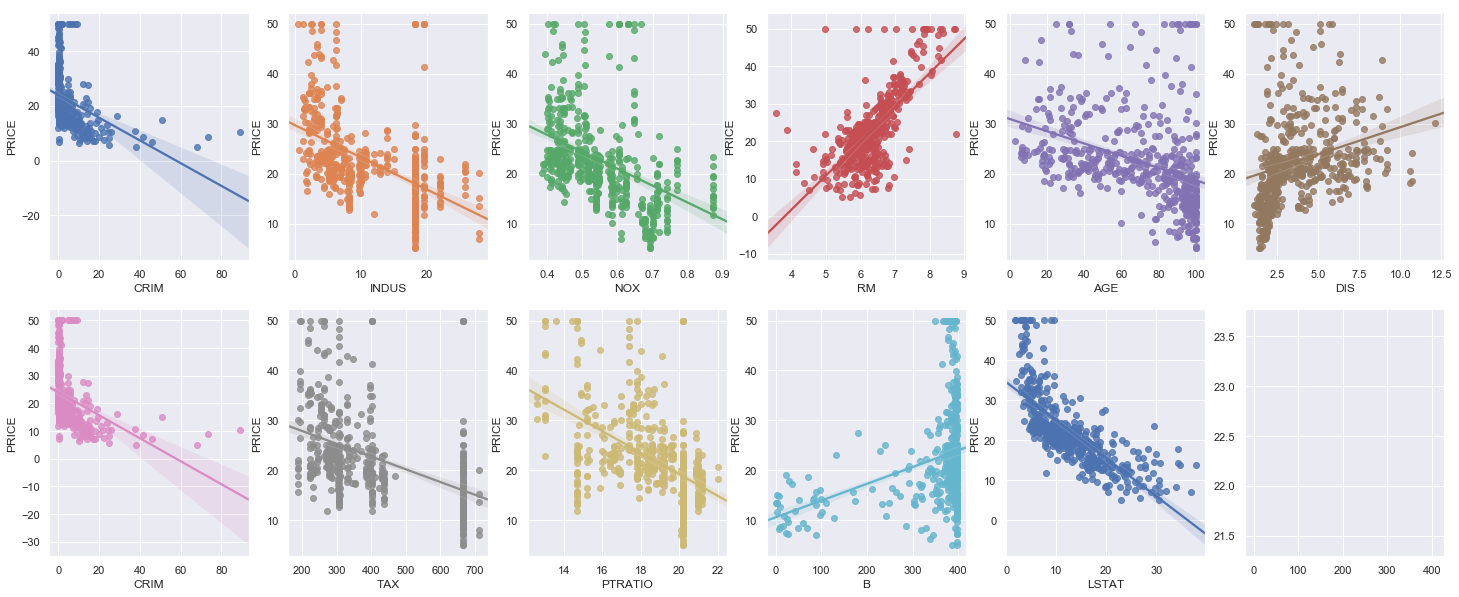

In [4]:
sns.set(color_codes=True)
fig, axs = plt.subplots(nrows=2,ncols=6,figsize=(25,10),squeeze=False)
for i,feat in enumerate(df.columns.drop(['PRICE','CHAS','RAD','ZN','LSTAT','B','PTRATIO','TAX'])):
    sns.regplot(x=feat, y='PRICE', data=df, ax=axs[0][i])
for i,feat in enumerate(df.columns.drop(['PRICE','CHAS','RAD','ZN','RAD','DIS','AGE','RM','NOX','INDUS'])):
    sns.regplot(x=feat, y='PRICE', data=df, ax=axs[1][i])

### Modelization

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('PRICE',axis=1), df.PRICE, test_size=0.3, random_state=10)

In [6]:
params = {'max_depth': 3, 'learning_rate':0.1, 'num_round':200}

booster=xgb.XGBRegressor(**params)
booster.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:56:50] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_round=200, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [7]:
r2_score(y_test, booster.predict(X_test))

0.8963630811711718

In [8]:
params = {'max_depth': 3, 'learning_rate':0.1, 'num_round':200}


X = df[['LSTAT']].values                        
y = df['PRICE'].values                          

sort_idx = X.flatten().argsort()
X = X[sort_idx]
y = y[sort_idx]

booster=xgb.XGBRegressor(**params) 
booster.fit(X, y)

[16:49:31] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_round=200, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

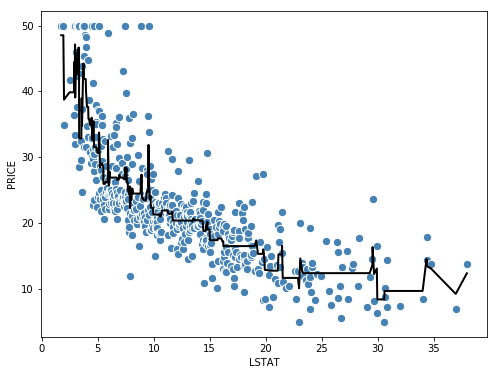

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y, c='steelblue',        
            edgecolor='white', s=70)
plt.plot(X, booster.predict(X),           
         color='black', lw=2)
plt.xlabel('LSTAT')
plt.ylabel('PRICE')
plt.show()


In [15]:
params['max_depth']

[1, 3, 5, 8]

In [16]:
params = {'max_depth': [1, 3, 5, 8], 'learning_rate':0.1, 'num_round':[4, 14, 50, 100]}

In [23]:
params = {'max_depth': [1, 3, 5, 8], 'learning_rate':0.1, 'num_round':[2, 14, 50, 200]}

X = df[['LSTAT']].values                        
y = df['PRICE'].values                          

sort_idx = X.flatten().argsort()
X = X[sort_idx]
y = y[sort_idx]


regressors = []
depths = [1, 3, 5, 8]
Y_test = []
for p in params['num_round']:
    model=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_round=p, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)
    model.fit(X, y)  # Processus d'optimisation de l'arbre
    Y_test.append(model.predict(X))  # On prédit sur les données et on ajoute à la liste des valeurs prédites
    regressors.append(model)

[16:54:26] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:26] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:26] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:26] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


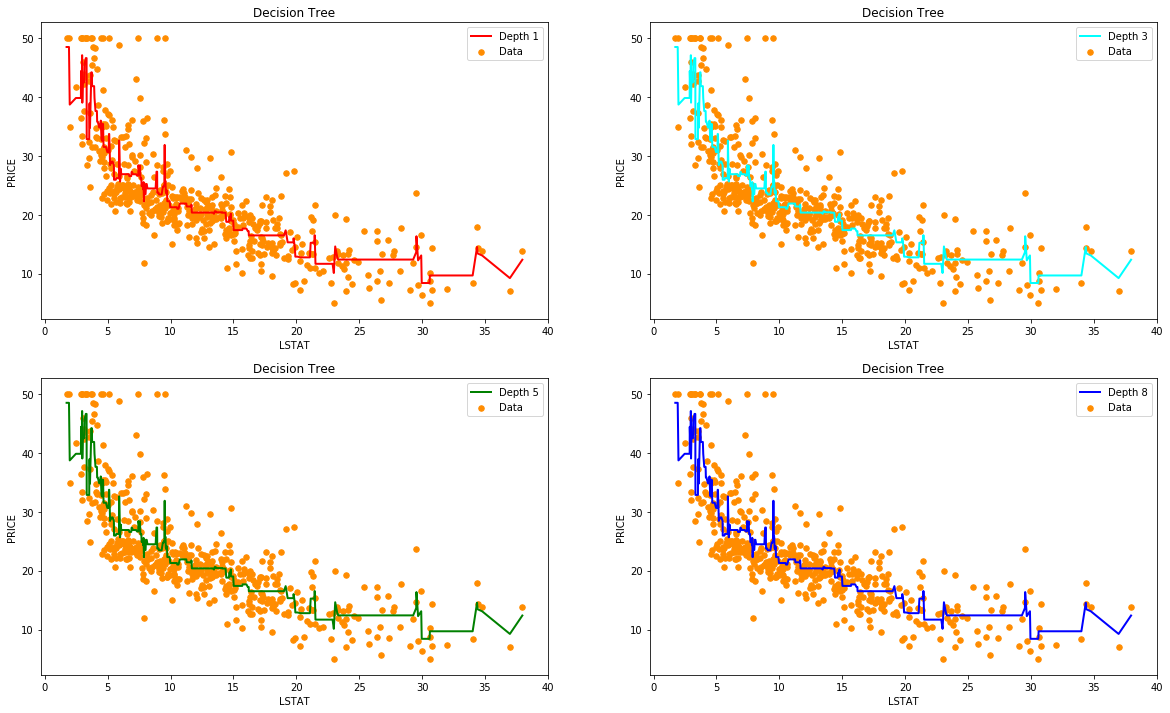

In [24]:
plt.figure(figsize=(20, 12))
colors = [ "red", "cyan", "green", "blue"]

for i, reg in zip(range(len(regressors)), regressors):
    plt.subplot(220 + i + 1)
    plt.plot(X, Y_test[i], color=colors[i], label="Depth {0}".format(depths[i]), linewidth=2)
    plt.scatter(X, y, s=30, c="darkorange", label="Data")
    plt.xlabel("LSTAT")
    plt.ylabel("PRICE")
    plt.title("Decision Tree")
    plt.legend()
    
plt.show()

#### Hyperparameters Optimization 

In [56]:
def tune_Kfold(max_depth, n_est):
    kf= KFold(n_splits=5, shuffle=True)
    out=[]
    for train_I, test_I in kf.split(df):
        X_fold_train = df.iloc[train_I, :].drop('PRICE',axis=1)
        y_fold_train = df['PRICE'].values[train_I]
        X_fold_test = df.iloc[test_I, :].drop('PRICE',axis=1)
        y_fold_test = df['PRICE'].values[test_I]
        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=max_depth, min_child_weight=1, missing=None, n_estimators=n_est,
       n_jobs=1, nthread=None, num_round=p, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=0)
        reg.fit(X_fold_train, y_fold_train)
        out.append(r2_score(y_fold_test, reg.predict(X_fold_test)))
    
    return np.mean(out)

In [57]:
grid_params = {
    'max_depth': np.arange(1,12,1),
    'n_estimator': np.arange(50,200,5)
}

cv_result = {
    'test_score': [],
    'parameters': []
}

for params in product(*grid_params.values()):
    
    cv_result['test_score'].append(tune_Kfold(params[0], params[1]))
    cv_result['parameters'].append(params)

In [66]:
def plot_grid_results(cv):
    score_matrix = np.asarray(cv["test_score"]).reshape((len(grid_params['max_depth']),len(grid_params['n_estimator'])))

    plt.figure(figsize=(22, 10))
    plt.title("Scores R2")
    sns.set(font_scale=1.5)
    annotations = np.array([[str("{:2.1f}".format(x * 100))
                              for x in row ] for row in score_matrix])
    ax = sns.heatmap(score_matrix, annot=annotations, fmt="",
               yticklabels=grid_params["max_depth"],
               xticklabels=grid_params["n_estimator"],annot_kws={"size":0.4*len(grid_params['n_estimator'])})
    ax.set(ylabel="max_depth", xlabel="n_estimator")

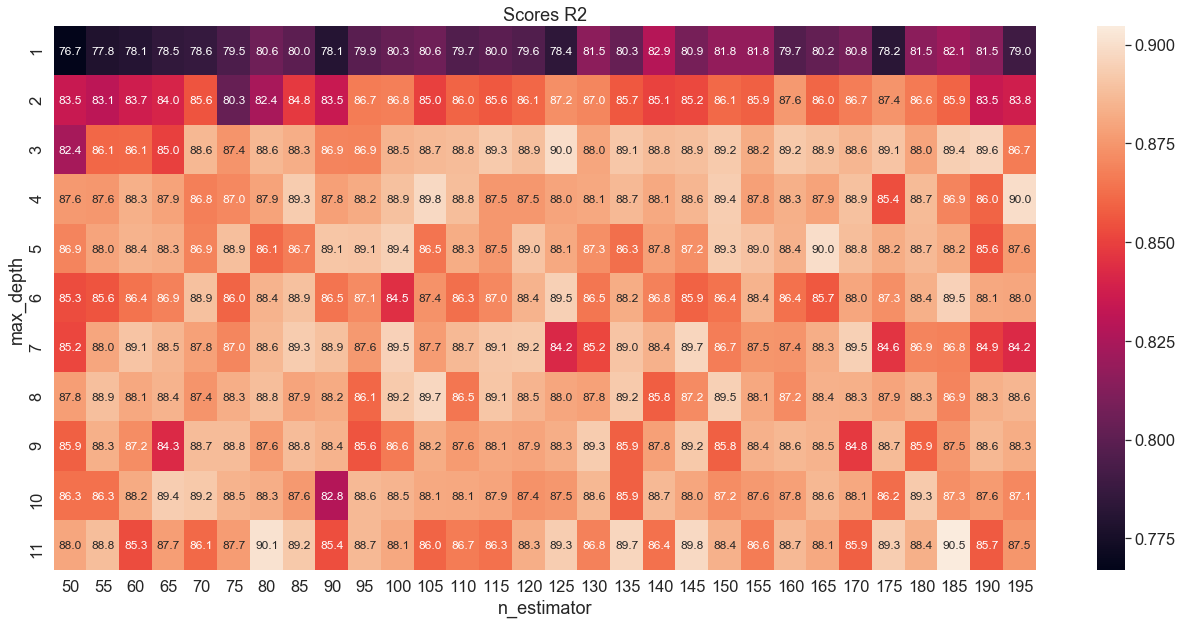

In [67]:
plot_grid_results(cv_result)

In [77]:
tune_Kfold(3, 160)

0.8925957646966871

##### Optimization II: Tuning with  GridSearchCV

In [51]:
kf= KFold(n_splits=5, shuffle=True)
grid_params = {
    'max_depth': np.arange(1,10,1),
    'n_estimators': np.arange(20,200,5),
}
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0, min_child_weight=1, missing=None,
       n_jobs=1, nthread=None, num_round=p,
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=0)
clf = GridSearchCV(reg, param_grid=grid_params, n_jobs=-1, cv=kf, refit=True)
clf.fit(df.drop('PRICE',axis=1), df.PRICE)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_round=200, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]), 'n_estimators': array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145,
       150, 155, 160, 165, 170, 175, 180, 185, 190, 195])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
      

In [52]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, num_round=200, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=0)

In [53]:
clf.best_params_

{'max_depth': 3, 'n_estimators': 150}

In [54]:
clf.n_splits_

5

In [55]:
clf.best_score_

0.6887138164829583

#### Validation

In [78]:
def r2(rep):
    rkf= RepeatedKFold(n_splits=5, n_repeats=rep, random_state=None)
    r2=[]
    for train_I, test_I in rkf.split(df):
        X_fold_train = df.iloc[train_I, :].drop('PRICE',axis=1)
        y_fold_train = df['PRICE'].values[train_I]
        X_fold_test = df.iloc[test_I, :].drop('PRICE',axis=1)
        y_fold_test = df['PRICE'].values[test_I]
        reg = clf.best_estimator_
        reg.fit(X_fold_train, y_fold_train)
        r2.append(r2_score(y_fold_test, reg.predict(X_fold_test)))
    
    print('The estimation of the r2 score over the test distributions is:', "{:2.2f}%".format(np.mean(r2)*100),'\u00B1', "{:2.2f}%".format(np.std(r2)*100))
    print("The confidence interval is [{:2.1f}%, {:2.1f}%]".format(*np.quantile(r2, q=[0.025, 0.975]) * 100))
    
    return r2

The estimation of the r2 score over the test distributions is: 87.87% ± 4.58%
The confidence interval is [76.5%, 93.6%]


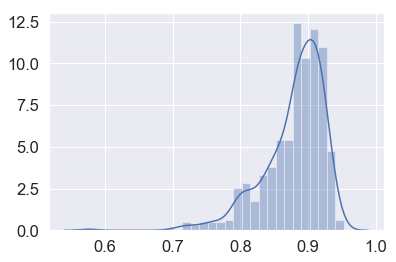

In [79]:
sns.distplot(r2(100),bins=30)

In [81]:
def MSE(rep,n):
    rkf= RepeatedKFold(n_splits=5, n_repeats=rep, random_state=None)
    MSE=[]
    for train_I, test_I in rkf.split(df):
        X_fold_train = df.iloc[train_I, :].drop('PRICE',axis=1)
        y_fold_train = df['PRICE'].values[train_I]
        X_fold_test = df.iloc[test_I, :].drop('PRICE',axis=1)
        y_fold_test = df['PRICE'].values[test_I]
        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=n,
       n_jobs=1, nthread=None, num_round=200, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=0)
        reg.fit(X_fold_train, y_fold_train)
        MSE.append(mean_squared_error(y_fold_test, reg.predict(X_fold_test)))
    print('The estimation of the MSE over the test distributions is:', "{:2.2f}".format(np.mean(MSE)),'\u00B1', "{:2.2f}".format(np.std(MSE)))
    print("The confidence interval is [{:2.1f}, {:2.1f}]".format(*np.quantile(MSE, q=[0.025, 0.975]) ))
    
    return MSE

The estimation of the MSE over the test distributions is: 216.73 ± 22.11
The confidence interval is [176.8, 264.3]
The estimation of the MSE over the test distributions is: 10.04 ± 3.66
The confidence interval is [5.7, 19.1]


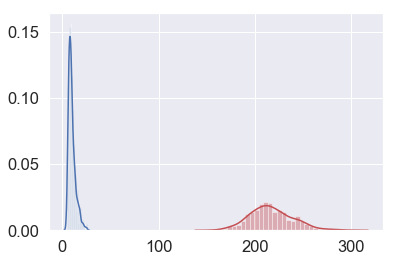

In [82]:
sns.distplot(MSE(100,5),bins=30,color='r')
sns.distplot(MSE(100,160),bins=30,color='b')

#### Intepretability 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('PRICE',axis=1), df.PRICE, test_size=0.3, random_state=10)

In [42]:
reg = clf.best_estimator_
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=130, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [47]:
features_imp = pd.DataFrame(
    data=np.asarray([df.columns.drop('PRICE'), reg.feature_importances_]).transpose(),
    columns=['Variable', 'Importance'])
features_imp

,Variable,Importance
0,CRIM,0.0778131
1,ZN,0.0118646
2,INDUS,0.0729242
3,CHAS,0.0045966
4,NOX,0.055946
5,RM,0.285361
6,AGE,0.0458246
7,DIS,0.058765
8,RAD,0.00775941
9,TAX,0.0332332


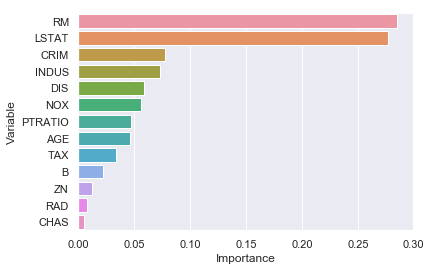

In [48]:
sns.barplot(y='Variable', x='Importance', data=features_imp.sort_values(by='Importance', ascending=False))